### Imports

In [1]:
import neptune as neptune
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker


# functions

In [2]:
def get_neptune_table(tags, negative_tags=None, columns=None):
    """
    Fetches a Neptune runs table filtered by tags and returns it as a pandas DataFrame.

    Parameters:
    - tags (list): List of tags to filter the runs.
    - negative_tags (list, optional): List of tags to exclude from the runs.
    - columns (list, optional): Additional columns to include in the runs table.

    Returns:
    - pandas.DataFrame: The runs table with the specified filters and columns.
    """
    # Initialize columns if None
    if columns is None:
        columns = []

    # Base columns to always include
    base_columns = ['sys/tags', 'sys/id', 'args/cutoff', 'args/batch_size', 'loss']
    columns.extend(base_columns)

    # Mapping for 'start' and 'end' arguments
    prefix_mapping = {
        'start': 'relative_lr',
        'end': 'relative_scheduler_fraction'
    }

    # Components to include in the arguments columns
    components = ['embedding_layer', 'head', 'gating', 'expert_inner_function', 'projection']

    # Build columns for each combination of 'start/end' and components
    for position in ['start', 'end']:
        for component in components:
            prefix = prefix_mapping[position]
            column_name = f'args/{prefix}/{component}'
            columns.append(column_name)

    # Initialize the Neptune project
    project = neptune.init_project(
        project="pmtest/llm-random",
        mode="read-only",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyMDY0ZDI5Ni05YWU3LTQyNGYtYmY4My1hZTFkY2EzYmUwMjgifQ=="
    )

    # Fetch the runs table with the specified tags and columns
    runs_table = project.fetch_runs_table(
        tag=tags,
        columns=columns
    ).to_pandas()

    # Ensure 'sys/tags' is a list for each run
    runs_table['sys/tags'] = runs_table['sys/tags'].apply(
        lambda x: x.split(',') if isinstance(x, str) else x
    )

    # Exclude runs containing any of the negative tags
    if negative_tags:
        for neg_tag in negative_tags:
            runs_table = runs_table[
                ~runs_table['sys/tags'].apply(lambda x: neg_tag in x)
            ]

    print(f'Table downloaded\nShape: {runs_table.shape}')
    return runs_table


In [3]:
def get_neptune_table_by_ids(run_ids):
    project = neptune.init_project(
        project="pmtest/llm-random",
        mode="read-only",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyMDY0ZDI5Ni05YWU3LTQyNGYtYmY4My1hZTFkY2EzYmUwMjgifQ=="
    )
    
    runs_table = project.fetch_runs_table(id=run_ids).to_pandas()
    
    print(f'table downloaded by IDs\nshape: {runs_table.shape}')
    return runs_table


In [4]:
def get_loss_per_step(runs_table):
    loss_dict = {}
    for _, run_row in runs_table.iterrows():
        run_id = run_row['sys/id']  # Assuming 'sys/id' is the run identifier
        print(f'run ID: {run_id}')
        project_name = "pmtest/llm-random"
        # run_id = "LLMRANDOM-2078"
        run = neptune.init_run(
            project=project_name,
            with_id=run_id,
            mode="read-only",
            api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyMDY0ZDI5Ni05YWU3LTQyNGYtYmY4My1hZTFkY2EzYmUwMjgifQ==",
        )
        loss_dict[run_id] = run[f"loss_interval/1"].fetch_values()
    return loss_dict

def df_per_step(df, per_step):
    # Calculate the rolling average of 'value' column with window size `per_step`
    df['value'] = df['value'].rolling(window=per_step, min_periods=1).mean()
    
    # Select every `per_step`-th row from the end backwards, excluding the first step
    selected_indices = list(range(len(df) - 1, 0, -per_step))  # Start from second last to skip the first step
    selected_rows = df.iloc[selected_indices]
    
    # Sort the selected rows to maintain ascending step order
    selected_rows = selected_rows.sort_index()
    
    return selected_rows

In [5]:
def calculate_speedup(a, b, equation):
    if equation == '(b-a)/b':
        speedup = (b - a) / b
    elif equation == '(b-a)/a':
        speedup = (b - a) / a
    elif equation == 'b/a':
        speedup = b / a
    else:
        return None

    return speedup

In [6]:
def plot_std(runs_spec_type, runs_1, runs_2, title, name_1, name_2, show_plot=False, save_to=None, figsize=(10, 10), ylim=None, x_start=None, loss_per=200):
    b_v_r_negative_tags = ['remove']
    if runs_spec_type == 'tags':
        table_1 = get_neptune_table(runs_1, b_v_r_negative_tags)
        table_2 = get_neptune_table(runs_2, b_v_r_negative_tags)
    elif runs_spec_type == 'ids':
        table_1 = get_neptune_table_by_ids(runs_1)
        table_2 = get_neptune_table_by_ids(runs_2)
    loss_dict_1 = get_loss_per_step(table_1)
    loss_dict_2 = get_loss_per_step(table_2)

    cutoff = table_1['args/cutoff'].iloc[0]
    batch_size = table_1['args/batch_size'].iloc[0]
    tokens_per_step = batch_size * cutoff

    only_2_runs = False
    if table_1.shape[0] + table_2.shape[0] == 2:
        only_2_runs = True

    # Concatenate the dataframes into one
    df_1 = pd.concat([df.set_index('step')['value'] for df in loss_dict_1.values()], axis=1)
    df_1 = df_per_step(df_1, loss_per)
    df_2 = pd.concat([df.set_index('step')['value'] for df in loss_dict_2.values()], axis=1)
    df_2 = df_per_step(df_2, loss_per)

    # Calculate mean and standard deviation
    df_1['mean'] = df_1.mean(axis=1)
    df_1['std'] = df_1.std(axis=1)

    # Calculate mean and standard deviation
    df_2['mean'] = df_2.mean(axis=1)
    df_2['std'] = df_2.std(axis=1)

    df_1['tokens'] = df_1.index * tokens_per_step
    df_2['tokens'] = df_2.index * tokens_per_step

    # Reset the index to have 'step' as a column again
    df_1 = df_1[['tokens', 'mean', 'std']].reset_index()
    df_2 = df_2[['tokens', 'mean', 'std']].reset_index()

    if show_plot:
        # Create the plot
        plt.figure(figsize=figsize)

        # baseline
        steps = df_1['tokens'].values
        mean_values = df_1['mean'].values
        std_values = df_1['std'].values

        if x_start is not None:
            first_index = np.argmax(steps > x_start)
            steps = steps[first_index:]
            mean_values = mean_values[first_index:]
            std_values = std_values[first_index:]

        if only_2_runs:
            plt.plot(steps, mean_values, label=f'{name_1}', color='blue')
        else:
            plt.plot(steps, mean_values, label=f'{name_1} - mean', color='blue')
            plt.fill_between(steps, mean_values - std_values, mean_values + std_values, 
                            color='blue', alpha=0.2, label=f'{name_1} - standard deviation')

        #relative
        steps = df_2['tokens'].values
        mean_values = df_2['mean'].values
        std_values = df_2['std'].values

        if x_start is not None:
            steps = steps[first_index:]
            mean_values = mean_values[first_index:]
            std_values = std_values[first_index:]
        
        if only_2_runs:
            plt.plot(steps, mean_values, label=f'{name_2}', color='red')
        else:
            plt.plot(steps, mean_values, label=f'{name_2} - mean', color='red')
            plt.fill_between(steps, mean_values - std_values, mean_values + std_values, 
                            color='red', alpha=0.2, label=f'{name_2} - standard deviation')

        # # Plot individual dataframes from the dictionary
        # for run_id, df in relative_loss_dict.items():
        #     plt.plot(df['step'].values, df['value'].values, label=f'Run {run_id}')

        # Add labels and title
        plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x*1e-9:.0f}B'))

        plt.xlabel('Tokens', fontsize=24)
        plt.ylabel('Loss', fontsize=24)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        
        if ylim is not None:
            plt.ylim(ylim)
        plt.title(title, fontsize=26)  # Set title font size x2
        # Show legend
        plt.legend(fontsize=20)
        if save_to is not None:
            plt.savefig(save_to)
        # Show the plot
        plt.show()

    # For baseline_df: Find the step with the lowest loss
    min_loss_index_baseline = df_1['mean'].idxmin()
    loss_baseline = df_1['mean'].values[min_loss_index_baseline]
    std_baseline = df_1['std'].values[min_loss_index_baseline]
    min_step_baseline = df_1['step'].values[min_loss_index_baseline]

    # For relative_df: Find the first step where the mean loss is smaller than the baseline's minimum loss
    smaller_loss_condition = df_2['mean'] <= loss_baseline

    if smaller_loss_condition.any():  # Check if there's any step with a smaller mean loss
        first_smaller_step_relative = df_2[smaller_loss_condition]['step'].values[0]
        loss_relative = df_2[smaller_loss_condition]['mean'].values[0]
        std_relative = df_2[smaller_loss_condition]['std'].values[0]
        
        # Calculate speedup using the found steps
        speedup = calculate_speedup(a=first_smaller_step_relative, b=min_step_baseline, equation='b/a')
    else:
        # No step has a smaller mean loss
        first_smaller_step_relative = None
        loss_relative = None
        std_relative = None
        speedup = None

    return (min_step_baseline, loss_baseline, std_baseline), (first_smaller_step_relative, loss_relative, std_relative), speedup

In [7]:
def results_dict_append(component_name, baseline, relative, speedup_relative, speedup_baseline, results_dict=None):
    # Unpack the tuples for easier readability
    (last_step_baseline, loss_baseline, std_baseline), (first_smaller_step_relative, loss_relative, std_relative) = baseline, relative
    
    # Check if results_dict is None and initialize if necessary
    if results_dict is None:
        results_dict = {
            'component': [],
            'total_tokens': [],
            'faster_tokens': [],
            'speedup_relative': [],
            'speedup_baseline': [],
        }

    # Calculate values to be added to the table
    total_tokens = last_step_baseline
    faster_tokens = first_smaller_step_relative if first_smaller_step_relative is not None else "N/A"
    speedup_relative = speedup_relative if speedup_relative is not None else "N/A"
    speedup_baseline = speedup_baseline if speedup_baseline is not None else "N/A"
    
    # Append results to the dictionary
    results_dict['component'].append(component_name)
    results_dict['total_tokens'].append(total_tokens)
    results_dict['faster_tokens'].append(faster_tokens)
    results_dict['speedup_relative'].append(speedup_relative)
    results_dict['speedup_baseline'].append(speedup_baseline)
    
    return results_dict


In [8]:
def plot_std_component(table, component_name, start_end, ax=None):
    print(f'component_name: {component_name}, start_end: {start_end}')
    se_convert = {
        'start': 'relative_lr',
        'end': 'relative_scheduler_fraction'
    }
    dict_name = se_convert[start_end]
    args_column = f'args/{dict_name}/{component_name}'

    filtered_table = table[table['sys/tags'].apply(lambda tags: component_name in tags and start_end in tags)]
    print(f'#runs completed: {filtered_table.shape[0]}')
    optimal_table = table[table['sys/tags'].apply(lambda tags: 'relative' in tags)]
    print(f'#runs completed (optimal): {optimal_table.shape[0]}')

    columns = ['loss', args_column]
    filtered_table = filtered_table[columns]

    x_1_table = filtered_table[filtered_table[args_column] == 1]
    filtered_table = filtered_table[filtered_table[args_column] != 1]

    grouped_data = filtered_table.groupby(args_column)['loss'].agg(['mean', 'min', 'max']).reset_index()
    x_1_data = x_1_table.groupby(args_column)['loss'].agg(['mean', 'min', 'max']).reset_index()
    optimal_grouped = optimal_table.groupby(args_column)['loss'].agg(['mean', 'min', 'max']).reset_index()

    if ax is None:
        fig, ax = plt.subplots()

    # Keep original x-values
    x_values = grouped_data[args_column].values
    x_1_values = x_1_data[args_column].values
    x_optimal = optimal_grouped[args_column].values

    # Print rounded values for debugging (optional)
    print(f'Rounded x_values: {np.round(x_values, 2)}')
    print(f'Rounded x_1_values: {np.round(x_1_values, 2)}')
    print(f'Rounded x_optimal: {np.round(x_optimal, 2)}')

    yerr = np.vstack([grouped_data['mean'] - grouped_data['min'], grouped_data['max'] - grouped_data['mean']])
    x_1_yerr = np.vstack([x_1_data['mean'] - x_1_data['min'], x_1_data['max'] - x_1_data['mean']])
    optimal_yerr = np.vstack([optimal_grouped['mean'] - optimal_grouped['min'], optimal_grouped['max'] - optimal_grouped['mean']])

    # Plot other relative and optimal relative
    line1 = ax.errorbar(x=x_values, y=grouped_data['mean'], yerr=yerr, fmt='o', color='blue', capsize=5, label='Other relative')
    line2 = ax.errorbar(x=x_optimal, y=optimal_grouped['mean'], yerr=optimal_yerr, fmt='o', color='green', label='RLRS', capsize=5)

    # Plot baseline (no relative) with LaTeX for lambda
    line3 = ax.errorbar(x=x_1_values, y=x_1_data['mean'], yerr=x_1_yerr, fmt='o', color='red', label=r'$\lambda = 1$', capsize=5)

    # Set the x-axis to a log scale
    ax.set_xscale('log')

    # Customize x-axis tick labels to display as regular numbers
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

    # Set x-ticks and gridlines for other relative and optimal relative data
    x_values_combined = np.concatenate((x_values, x_optimal))  # Combine relevant x-values
    x_values_combined = np.unique(x_values_combined)  # Ensure unique values

    # Remove second-first and second-last x-ticks
    if len(x_values_combined) > 4:  # Make sure we have enough ticks
        x_values_combined = np.delete(x_values_combined, [1, -2])

    # Set ticks and manually set rounded labels
    ax.set_xticks(x_values_combined)
    ax.set_xticklabels(np.round(x_values_combined, 2))

    ax.grid(True, which='major', linestyle='--', linewidth=0.5)  # Keep the grid for relevant data

    # Return the line objects for the shared legend
    return line1, line2, line3

In [9]:
def U_plot(
    model_name, 
    u_plot_table,
    component_names, 
    start_ends,
    figsize=(25, 10),
    ylim=(3, 4),
    title_fontsize=20, 
    xlabel_fontsize=18, 
    ylabel_fontsize=18, 
    tick_fontsize=14,
    legend_fontsize=16,
    row_spacing=1.0,
    legend_spacing=0.05  # Add parameter to control space between legend and plot
):
    # Simplified titles for each column
    names_converter = {
        'embedding_layer': 'Embedding',
        'head': 'Unembedding',
        'gating': 'Router',
        'expert_inner_function': 'Expert',
        'projection': 'Attention',
    }

    print(f'There are {u_plot_table.shape[0]} runs')

    # Create subplots with 2 rows and 5 columns
    fig, axs = plt.subplots(len(start_ends), len(component_names), sharey=True, figsize=figsize)

    # List to collect the lines for the shared legend
    all_lines = []

    # Loop through components and start_ends
    for i, start_end in enumerate(start_ends):
        for j, name in enumerate(component_names):
            ax = axs[i, j]
            line1, line2, line3 = plot_std_component(table=u_plot_table, component_name=name, start_end=start_end, ax=ax)
            all_lines = [line1, line2, line3]
            
            # Only add the title for the top subplot (first row) in each column
            if i == 0:
                ax.set_title(f'{names_converter[name]}', fontsize=title_fontsize)
            
            # Only add y-axis labels for the first column in each row
            if j == 0:
                ax.set_ylabel('Loss', fontsize=ylabel_fontsize)
            else:
                ax.set_ylabel("")  # Remove the y-axis label for other subplots in the row

            # Set x-axis labels with correct LaTeX formatting using \mathit
            if i == 0:
                ax.set_xlabel(r'$\lambda_{\mathit{start}}^{\mathit{' + f'{names_converter[name]}' + '}}$', fontsize=xlabel_fontsize)
            else:
                ax.set_xlabel(r'$\lambda_{\mathit{end}}^{\mathit{' + f'{names_converter[name]}' + '}}$', fontsize=xlabel_fontsize)
            
            # Rotate x-axis labels and set tick font sizes
            for label in ax.get_xticklabels():
                label.set_rotation(45)
            ax.tick_params(axis='x', labelsize=tick_fontsize)
            ax.tick_params(axis='y', labelsize=tick_fontsize)

    # Adjust y-limits for all subplots
    for ax in axs.flat:
        ax.set_ylim(ylim)

    # Add shared legend with controlled spacing
    fig.legend(handles=[line1, line2, line3], labels=['Varying ' + r'$\lambda$', 'RLRS', r'$\lambda = 1$'],
               loc='upper center', fontsize=legend_fontsize, ncol=3, bbox_to_anchor=(0.5, 1 + legend_spacing), bbox_transform=fig.transFigure)

    # Adjust layout to make room for labels
    plt.tight_layout()
    plt.subplots_adjust(hspace=row_spacing, top=0.85 - legend_spacing)  # Adjust row spacing and top margin here
    plt.savefig(f'plots/U-plots-{model_name}.pdf')
    plt.show()


#### Other functions

In [10]:
def U_plot_component(
    model_name, 
    u_plot_table, 
    component_name,  # Single component argument
    start_ends,
    figsize=(12, 5),  # Adjusted figure size for a single row
    ylim=(3, 4),
    title_fontsize=20, 
    xlabel_fontsize=18, 
    ylabel_fontsize=18, 
    tick_fontsize=14,
    legend_fontsize=16,
    row_spacing=1.0,
    legend_spacing=0.05  # Control space between legend and plot
):
    # Simplified title for the single component
    names_converter = {
        'embedding_layer': 'Embedding',
        'head': 'Unembedding',
        'gating': 'Router',
        'expert_inner_function': 'Expert',
        'projection': 'Attention',
    }

    print(f'There are {u_plot_table.shape[0]} runs')

    # Create subplots with 1 row and len(start_ends) columns
    fig, axs = plt.subplots(1, len(start_ends), sharey=True, figsize=figsize)

    # List to collect the lines for the shared legend
    all_lines = []

    # Loop through start_ends (only one component in a row)
    for i, start_end in enumerate(start_ends):
        ax = axs[i]
        line1, line2, line3 = plot_std_component(table=u_plot_table, component_name=component_name, start_end=start_end, ax=ax)
        
        # Add y-axis label for the first subplot in the row
        if i == 0:
            ax.set_ylabel('Loss', fontsize=ylabel_fontsize)

        # Set title for each plot based on start_end
        ax.set_title(f'{names_converter[component_name]} ({start_end})', fontsize=title_fontsize)

        # Set x-axis labels with correct LaTeX formatting using \mathit
        if start_end == 'start':
            ax.set_xlabel(r'$\lambda_{\mathit{start}}^{\mathit{' + f'{names_converter[component_name]}' + '}}$', fontsize=xlabel_fontsize)
        else:
            ax.set_xlabel(r'$\lambda_{\mathit{end}}^{\mathit{' + f'{names_converter[component_name]}' + '}}$', fontsize=xlabel_fontsize)
        
        # Rotate x-axis labels and set tick font sizes
        for label in ax.get_xticklabels():
            label.set_rotation(45)
        ax.tick_params(axis='x', labelsize=tick_fontsize)
        ax.tick_params(axis='y', labelsize=tick_fontsize)

    # Adjust y-limits for all subplots
    for ax in axs.flat:
        ax.set_ylim(ylim)

    # Add shared legend with controlled spacing
    fig.legend(handles=[line1, line2, line3], labels=['Varying ' + r'$\lambda$', 'RLRS'],
               loc='upper center', fontsize=legend_fontsize, ncol=3, bbox_to_anchor=(0.5, 1 + legend_spacing), bbox_transform=fig.transFigure)

    # Adjust layout to make room for labels
    plt.tight_layout()
    plt.subplots_adjust(hspace=row_spacing, top=0.85 - legend_spacing)  # Adjust row spacing and top margin here
    plt.savefig(f'U-plot-{names_converter[component_name]}.pdf')
    plt.show()


# Main

## Medium (30M)

https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (6, 5)
https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (6, 15)
run ID: LLMRANDOM-16160
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16160
run ID: LLMRANDOM-16157
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16157
run ID: LLMRANDOM-16156
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16156
run ID: LLMRANDOM-16113
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16113
run ID: LLMRANDOM-16112
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16112
run ID: LLMRANDOM-16108
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16108
run ID: LLMRANDOM-16159
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16159
run ID: LLMRANDOM-16158
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16158
run ID: LLMRANDOM-16155
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16155
run ID: LLMRANDOM-16120
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16120
run ID: LLMRANDOM-16119

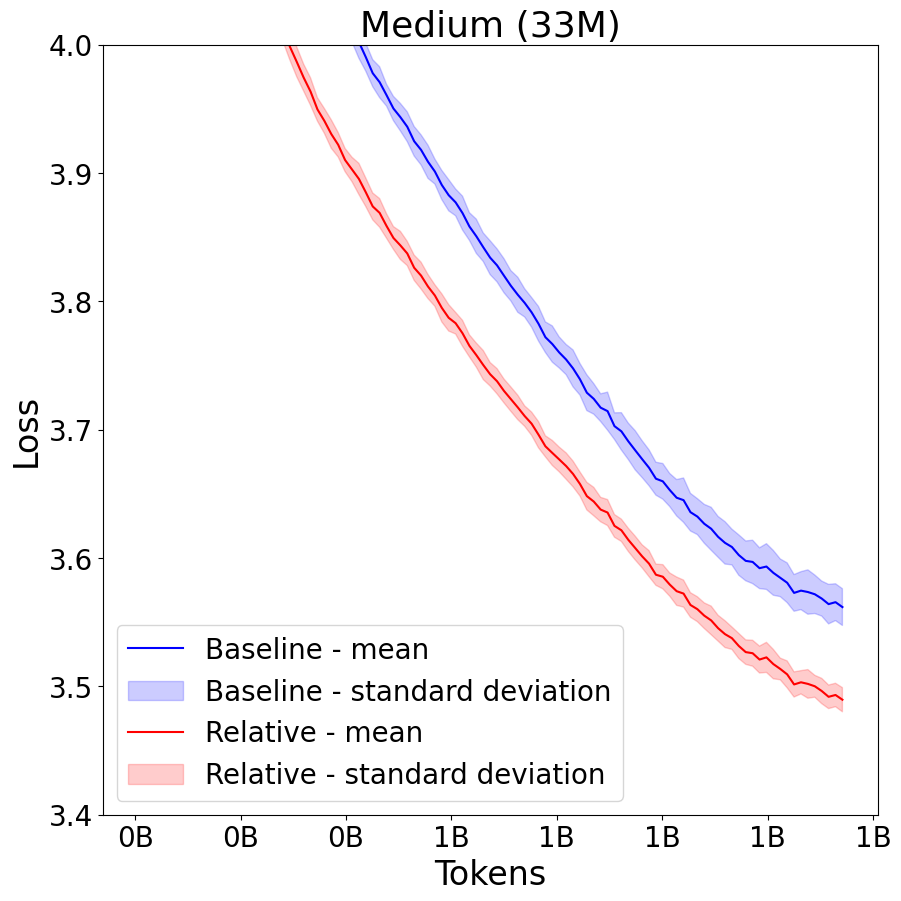

speedup: 1.257985257985258
total tokens: 671.0M, relative tokens: 533.0M
std baseline: 0.014324899247255145, std relative: 0.009704952584557584


In [11]:
b_v_r_tags_baseline = ['relativity_paper', 'medium_model', 'std', 'baseline']
b_v_r_tags_relative = ['relativity_paper', 'medium_model', 'std', 'relative']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), speedup = plot_std(
    runs_spec_type='tags',
    runs_1=b_v_r_tags_baseline,
    runs_2=b_v_r_tags_relative,
    title='Medium (33M)',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to='plots/medium_relative_vs_baseline.pdf',
    ylim=(3.4, 4),
    x_start=0,
    loss_per=100,
)

print(f'speedup: {speedup}')
tokens_per_step = 128 * 512
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000, 0)}M, relative tokens: {round(relative_steps * tokens_per_step / 1000000, 0)}M')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

## Base (100M)

https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (10, 5)
https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (3, 15)
run ID: LLMRANDOM-18593
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-18593
run ID: LLMRANDOM-18592
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-18592
run ID: LLMRANDOM-18591
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-18591
run ID: LLMRANDOM-18590
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-18590
run ID: LLMRANDOM-18589
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-18589
run ID: LLMRANDOM-18588
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-18588
run ID: LLMRANDOM-18587
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-18587
run ID: LLMRANDOM-16077
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16077
run ID: LLMRANDOM-16076
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16076
run ID: LLMRANDOM-16075
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16075
run ID: LLMRANDOM-1576

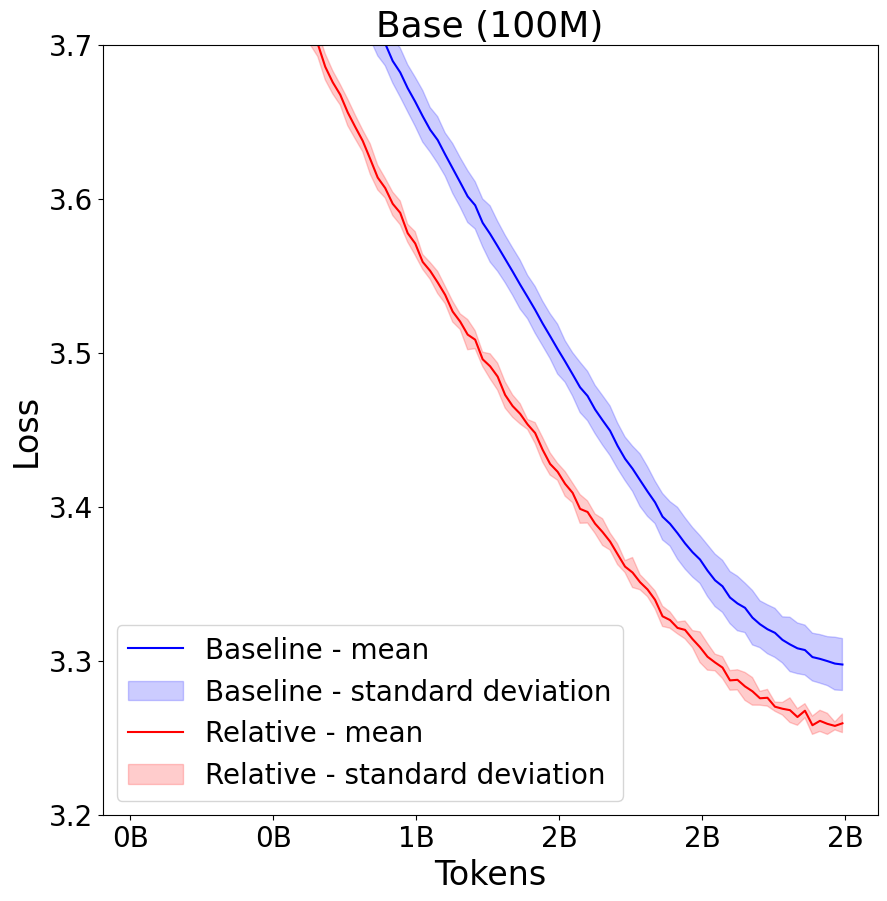

speedup: 1.2025316455696202
total tokens: 2.49B, relative tokens: 2.07B
std baseline: 0.01683432654796398, std relative: 0.007071811055892349


In [12]:
b_v_r_tags_baseline = ['relativity_paper', 'base_model', 'std', 'baseline']
b_v_r_tags_relative = ['relativity_paper', 'base_model', 'std', 'relative']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), speedup = plot_std(
    runs_spec_type='tags',
    runs_1=b_v_r_tags_baseline,
    runs_2=b_v_r_tags_relative,
    title='Base (100M)',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to='plots/base_relative_vs_baseline.pdf',
    ylim=(3.2, 3.7),
    x_start=0,
    loss_per=200,
)

print(f'speedup: {speedup}')
tokens_per_step = 256 * 512
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000000, 2)}B, relative tokens: {round(relative_steps * tokens_per_step / 1000000000, 2)}B')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

## Large (1B)

https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (6, 5)
https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (3, 15)
run ID: LLMRANDOM-18688
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-18688
run ID: LLMRANDOM-18618
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-18618
run ID: LLMRANDOM-18617
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-18617
run ID: LLMRANDOM-16073
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16073
run ID: LLMRANDOM-16028
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16028
run ID: LLMRANDOM-14973
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14973
run ID: LLMRANDOM-16020
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16020
run ID: LLMRANDOM-16005
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16005
run ID: LLMRANDOM-15082
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15082


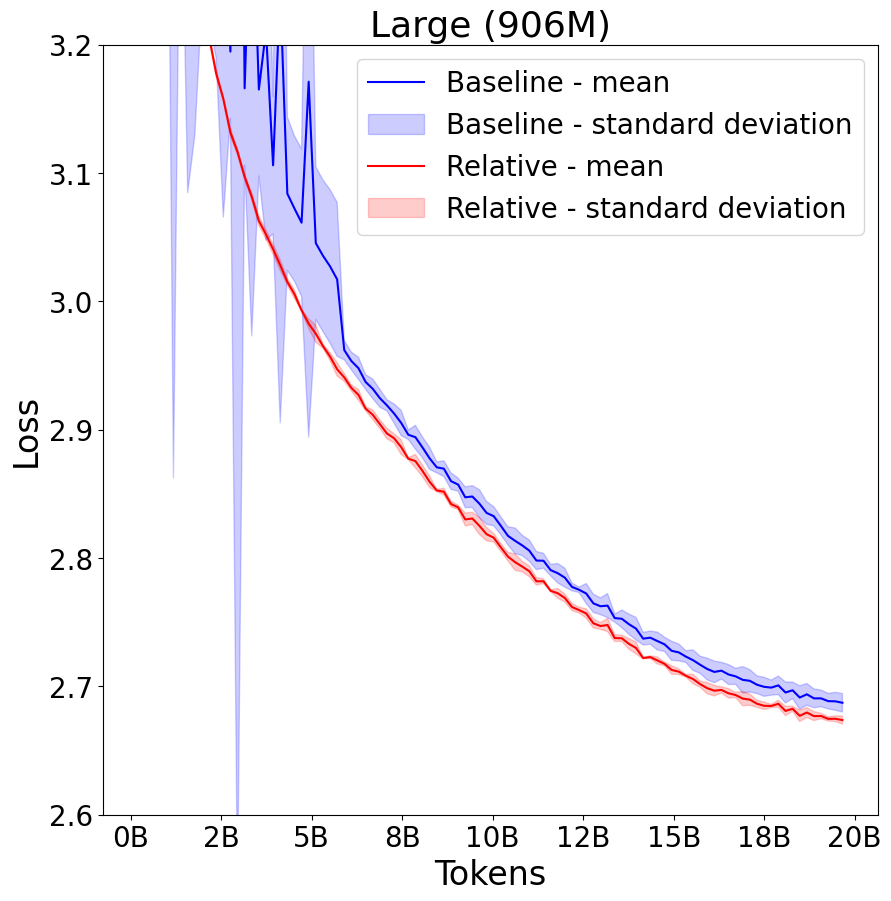

speedup: 1.1363636363636365
total tokens: 19.66B, relative tokens: 17.3B
std baseline: 0.007194473083255771, std relative: 0.00275787535953905


In [13]:
b_v_r_tags_baseline = ['relativity_paper', 'large_model', 'std', 'baseline']
b_v_r_tags_relative = ['relativity_paper', 'large_model', 'std', 'relative']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), speedup = plot_std(
    runs_spec_type='tags',
    runs_1=b_v_r_tags_baseline,
    runs_2=b_v_r_tags_relative,
    title='Large (906M)',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to='plots/base_relative_vs_baseline.pdf',
    ylim=(2.6, 3.2),
    x_start=0,
    loss_per=500,
)

print(f'speedup: {speedup}')
tokens_per_step = 384 * 1024
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000000, 2)}B, relative tokens: {round(relative_steps * tokens_per_step / 1000000000, 2)}B')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

## Base (100M) Long

https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (3, 5)
https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (3, 15)
run ID: LLMRANDOM-16011
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16011
run ID: LLMRANDOM-16010
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16010
run ID: LLMRANDOM-16009
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16009
run ID: LLMRANDOM-16008
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16008
run ID: LLMRANDOM-16007
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16007
run ID: LLMRANDOM-16006
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16006


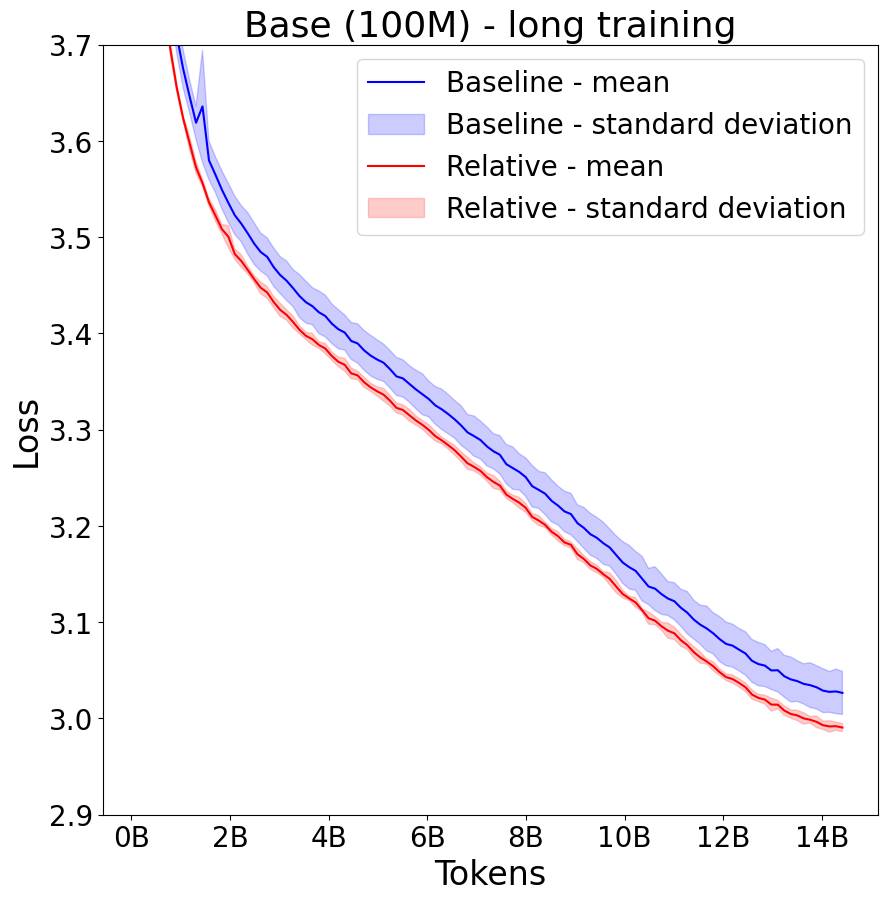

speedup: 1.1458333333333333
total tokens: 14.42B, relative tokens: 12.58B
std baseline: 0.022482960670423605, std relative: 0.004809887021174904


In [14]:
b_v_r_tags_baseline = ['relativity_paper', 'base_model', 'long', 'baseline']
b_v_r_tags_relative = ['relativity_paper', 'base_model', 'long', 'relative']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), speedup = plot_std(
    runs_spec_type='tags',
    runs_1=b_v_r_tags_baseline,
    runs_2=b_v_r_tags_relative,
    title='Base (100M) - long training',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to='plots/base_long_relative_vs_baseline.pdf',
    ylim=(2.9, 3.7),
    x_start=0,
    loss_per=1000,
)

print(f'speedup: {speedup}')
tokens_per_step = 256 * 512
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000000, 2)}B, relative tokens: {round(relative_steps * tokens_per_step / 1000000000, 2)}B')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

## Dense

### Medium

https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (3, 5)
https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (3, 11)
run ID: LLMRANDOM-16037
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16037
run ID: LLMRANDOM-16036
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16036
run ID: LLMRANDOM-16035
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16035
run ID: LLMRANDOM-16040
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16040
run ID: LLMRANDOM-16039
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16039
run ID: LLMRANDOM-16038
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16038


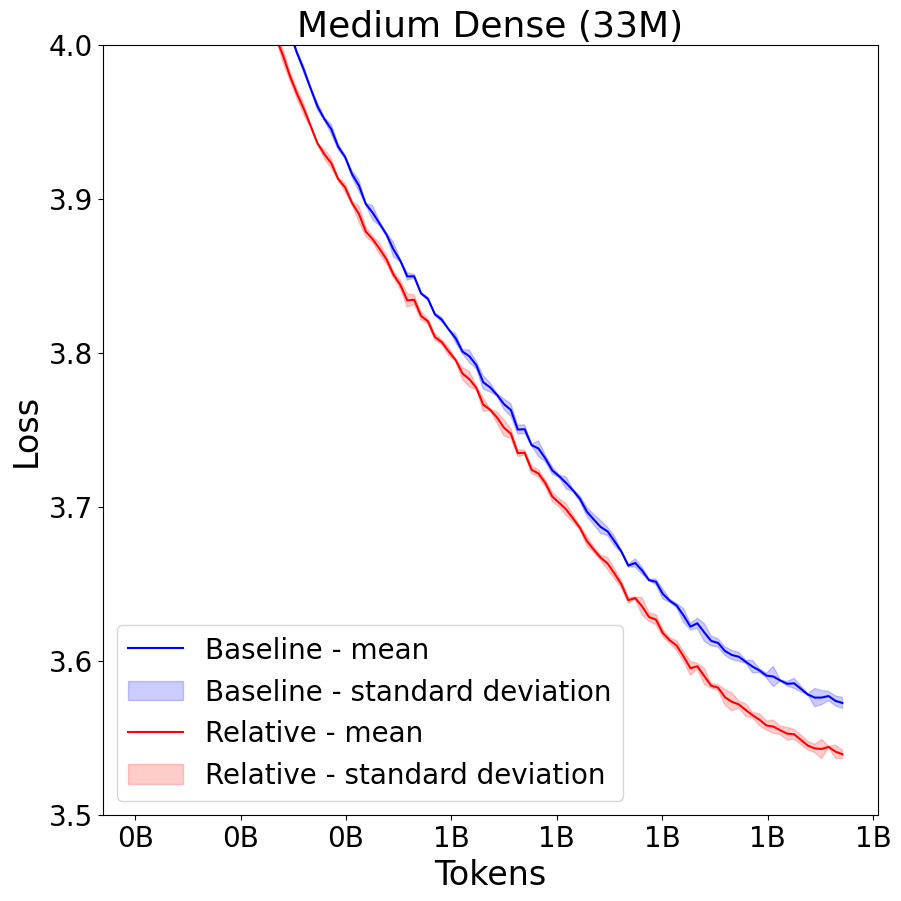

speedup: 1.17162471395881
total tokens: 1342.0M, relative tokens: 1146.0M
std baseline: 0.0035950707114240513, std relative: 0.002272704307363206


In [15]:
b_v_r_tags_baseline = ['relativity_paper', 'dense', 'medium_model', 'baseline']
b_v_r_tags_relative = ['relativity_paper', 'dense', 'medium_model', 'relative']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), speedup = plot_std(
    runs_spec_type='tags',
    runs_1=b_v_r_tags_baseline,
    runs_2=b_v_r_tags_relative,
    title='Medium Dense (33M)',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to='plots/medium_dense_relative_vs_baseline.pdf',
    ylim=(3.5, 4),
    x_start=0,
    loss_per=100,
)

print(f'speedup: {speedup}')
tokens_per_step = 256 * 512
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000, 0)}M, relative tokens: {round(relative_steps * tokens_per_step / 1000000, 0)}M')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

### Base

https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (3, 5)
https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (3, 11)
run ID: LLMRANDOM-18906
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-18906
run ID: LLMRANDOM-18905
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-18905
run ID: LLMRANDOM-18904
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-18904
run ID: LLMRANDOM-18909
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-18909
run ID: LLMRANDOM-18908
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-18908
run ID: LLMRANDOM-18907
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-18907


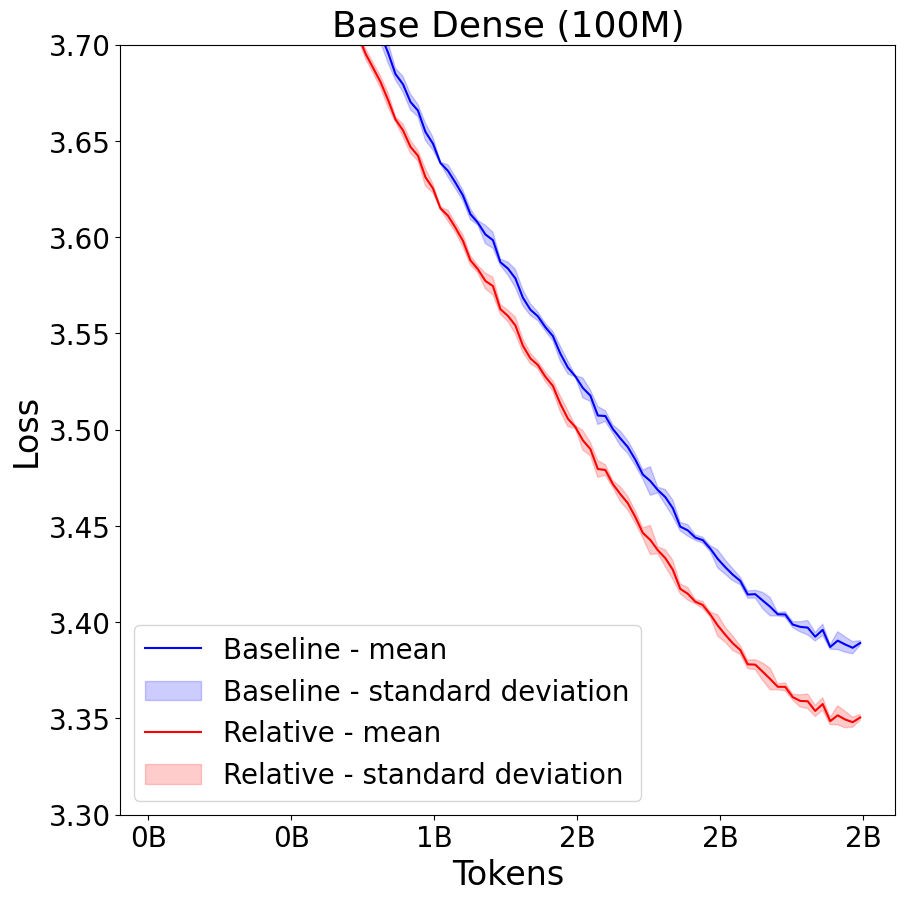

speedup: 1.1898734177215189
total tokens: 2464.0M, relative tokens: 2071.0M
std baseline: 0.003172129954347042, std relative: 0.0022514137253622545


In [11]:
b_v_r_tags_baseline = ['relativity_paper', 'dense', 'base_model', 'baseline', 'std']
b_v_r_tags_relative = ['relativity_paper', 'dense', 'base_model', 'relative', 'std']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), speedup = plot_std(
    runs_spec_type='tags',
    runs_1=b_v_r_tags_baseline,
    runs_2=b_v_r_tags_relative,
    title='Base Dense (100M)',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to='plots/base_dense_relative_vs_baseline.pdf',
    ylim=(3.3, 3.7),
    x_start=0,
    loss_per=200,
)

print(f'speedup: {speedup}')
tokens_per_step = 256 * 512
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000, 0)}M, relative tokens: {round(relative_steps * tokens_per_step / 1000000, 0)}M')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

### Large (1B)

https://app.neptune.ai/pmtest/llm-random/
table downloaded by IDs
shape: (1, 476)
https://app.neptune.ai/pmtest/llm-random/
table downloaded by IDs
shape: (1, 492)
run ID: LLMRANDOM-13393
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13393
run ID: LLMRANDOM-13404
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13404


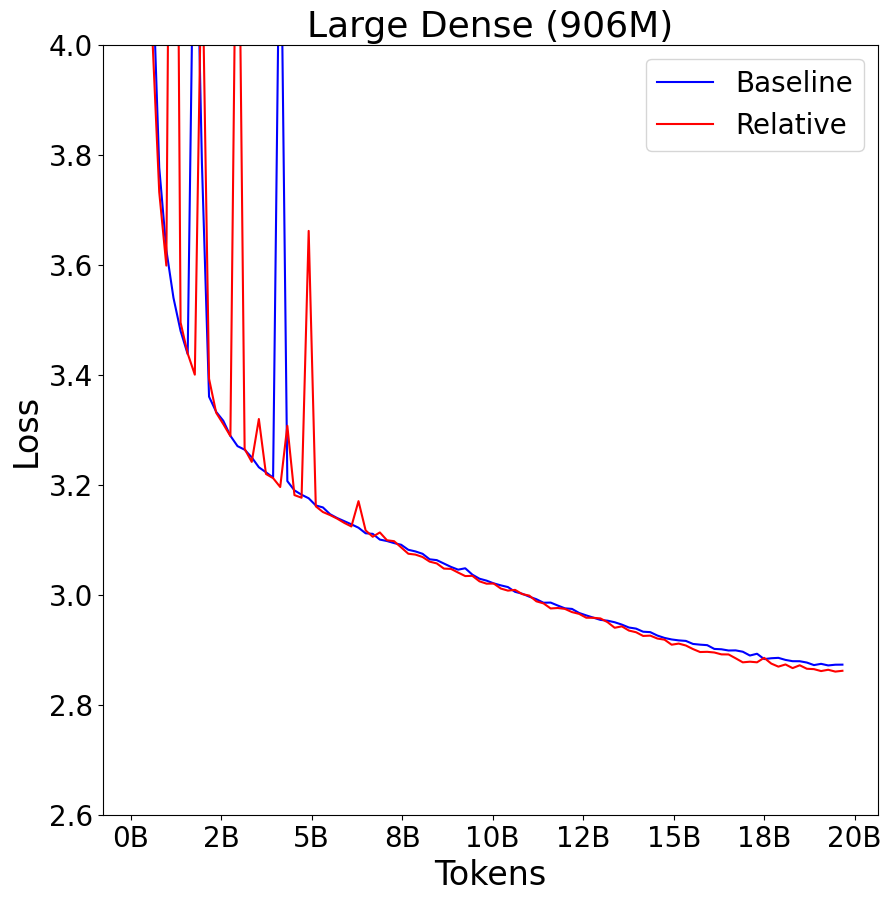

speedup: 1.0769230769230769
total tokens: 19.0B, relative tokens: 18.0B
std baseline: 0.0, std relative: 0.0


In [17]:
runs_baseline= ['LLMRANDOM-13393']
runs_relative= ['LLMRANDOM-13404']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), speedup = plot_std(
    runs_spec_type='ids',
    runs_1=runs_baseline,
    runs_2=runs_relative,
    title='Large Dense (906M)',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to='plots/large_dense_relative_vs_baseline.pdf',
    ylim=(2.6, 4),
    x_start=0,
    loss_per=500,
)

print(f'speedup: {speedup}')
tokens_per_step = 384 * 1024
print(f'total tokens: {round(all_steps * tokens_per_step / 1e9, 0)}B, relative tokens: {round(relative_steps * tokens_per_step / 1e9, 0)}B')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

# Ablations

## U-plots

### Medium (30M)

In [44]:
u_plot_tags = ['relativity_paper', 'medium_model', 'uplot']
u_plot_negative_tags = ['remove']

table = get_neptune_table(tags=u_plot_tags, negative_tags=u_plot_negative_tags)

https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (980, 15)


There are 980 runs
component_name: embedding_layer, start_end: start
#runs completed: 97
#runs completed (optimal): 10
Rounded x_values: [ 0.62  0.83  1.25  2.5  10.   20.   30.   40.  ]
Rounded x_1_values: [1.]
Rounded x_optimal: [5.]
component_name: head, start_end: start
#runs completed: 97
#runs completed (optimal): 10
Rounded x_values: [0.08 0.11 0.17 0.33 1.33 2.66 4.   5.33]
Rounded x_1_values: [1.]
Rounded x_optimal: [0.67]
component_name: gating, start_end: start
#runs completed: 97
#runs completed (optimal): 10
Rounded x_values: [0.08 0.11 0.17 0.33 1.33 2.66 4.   5.33]
Rounded x_1_values: [1.]
Rounded x_optimal: [0.67]
component_name: expert_inner_function, start_end: start
#runs completed: 97
#runs completed (optimal): 10
Rounded x_values: [0.04 0.05 0.08 0.15 0.6  1.2  1.8  2.4 ]
Rounded x_1_values: [1.]
Rounded x_optimal: [0.3]
component_name: projection, start_end: start
#runs completed: 97
#runs completed (optimal): 10
Rounded x_values: [0.12 0.17 0.25 0.5  2.   4.   6.

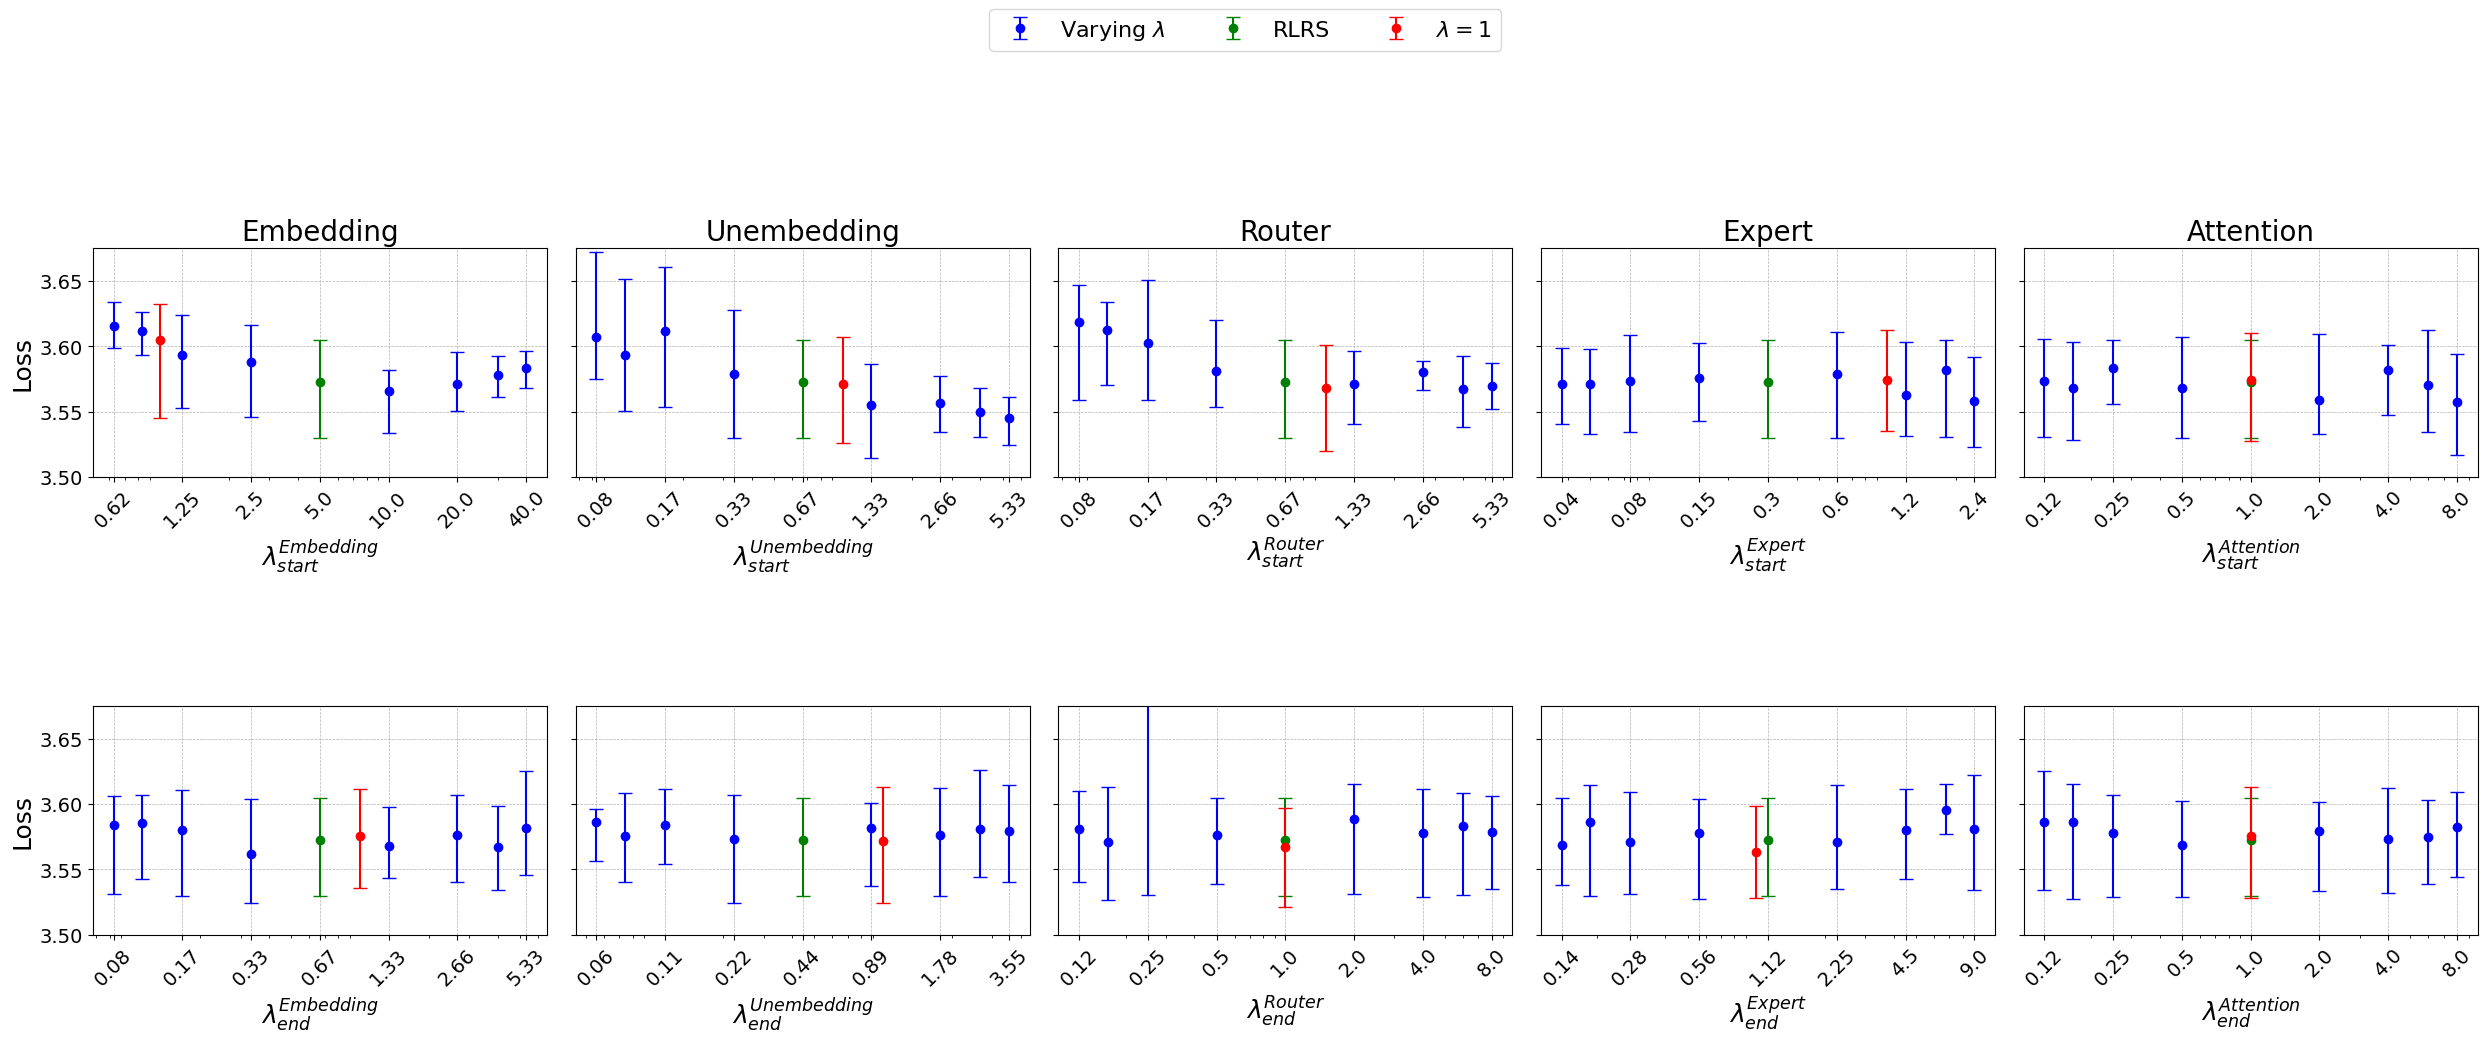

In [45]:
component_names = ['embedding_layer', 'head', 'gating', 'expert_inner_function', 'projection']
start_ends = ['start', 'end']
model_name = 'Medium (30M)'

U_plot(
    model_name=model_name,
    u_plot_table=table,
    component_names=component_names,
    start_ends=start_ends,
    ylim=(3.5, 3.675)
)

### Base (100M)

In [48]:
u_plot_tags = ['relativity_paper', 'base_model', 'uplot']
u_plot_negative_tags = ['remove']

table = get_neptune_table(tags=u_plot_tags, negative_tags=u_plot_negative_tags)

https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (932, 15)


There are 932 runs
component_name: embedding_layer, start_end: start
#runs completed: 90
#runs completed (optimal): 10
Rounded x_values: [ 0.62  0.83  1.25  2.5  10.   20.   30.   40.  ]
Rounded x_1_values: [1.]
Rounded x_optimal: [5.]
component_name: head, start_end: start
#runs completed: 90
#runs completed (optimal): 10
Rounded x_values: [0.08 0.11 0.17 0.33 1.33 2.66 4.   5.33]
Rounded x_1_values: [1.]
Rounded x_optimal: [0.67]
component_name: gating, start_end: start
#runs completed: 90
#runs completed (optimal): 10
Rounded x_values: [0.08 0.11 0.17 0.33 1.33 2.66 4.   5.33]
Rounded x_1_values: [1.]
Rounded x_optimal: [0.67]
component_name: expert_inner_function, start_end: start
#runs completed: 90
#runs completed (optimal): 10
Rounded x_values: [0.04 0.05 0.08 0.15 0.6  1.2  1.8  2.4 ]
Rounded x_1_values: [1.]
Rounded x_optimal: [0.3]
component_name: embedding_layer, start_end: end
#runs completed: 90
#runs completed (optimal): 10
Rounded x_values: [0.08 0.11 0.17 0.33 1.33 2.66

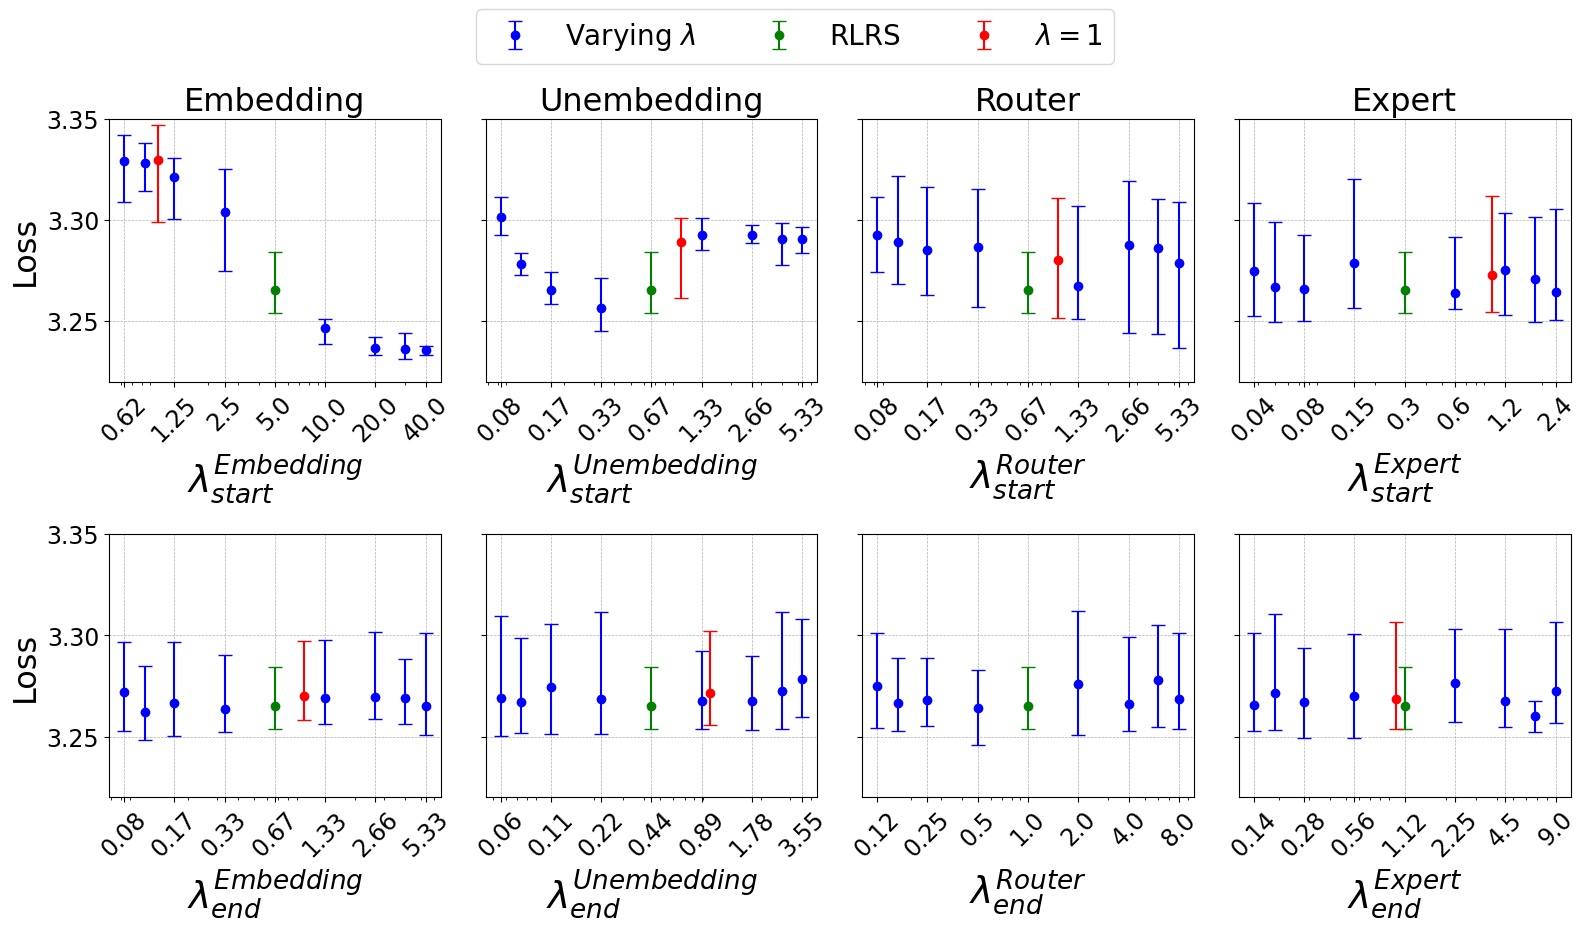

In [49]:
# component_names = ['embedding_layer', 'head', 'gating', 'expert_inner_function', 'projection']
component_names = ['embedding_layer', 'head', 'gating', 'expert_inner_function']
start_ends = ['start', 'end']
model_name = 'Base (100M)'

U_plot(
    model_name=model_name,
    u_plot_table=table,
    component_names=component_names,
    start_ends=start_ends,
    figsize=(16, 9.5),
    ylim=(3.22, 3.35),
    title_fontsize=23, 
    xlabel_fontsize=27, 
    ylabel_fontsize=23, 
    tick_fontsize=17,
    legend_fontsize=20,
    row_spacing=0.58,
    legend_spacing=-0.01
)

### Attention

There are 932 runs
component_name: projection, start_end: start
#runs completed: 86
#runs completed (optimal): 10
Rounded x_values: [0.12 0.17 0.25 0.5  2.   4.   6.   8.  ]
Rounded x_1_values: [1.]
Rounded x_optimal: [1.]
component_name: projection, start_end: end
#runs completed: 87
#runs completed (optimal): 10
Rounded x_values: [0.12 0.17 0.25 0.5  2.   4.   6.   8.  ]
Rounded x_1_values: [1.]
Rounded x_optimal: [1.]


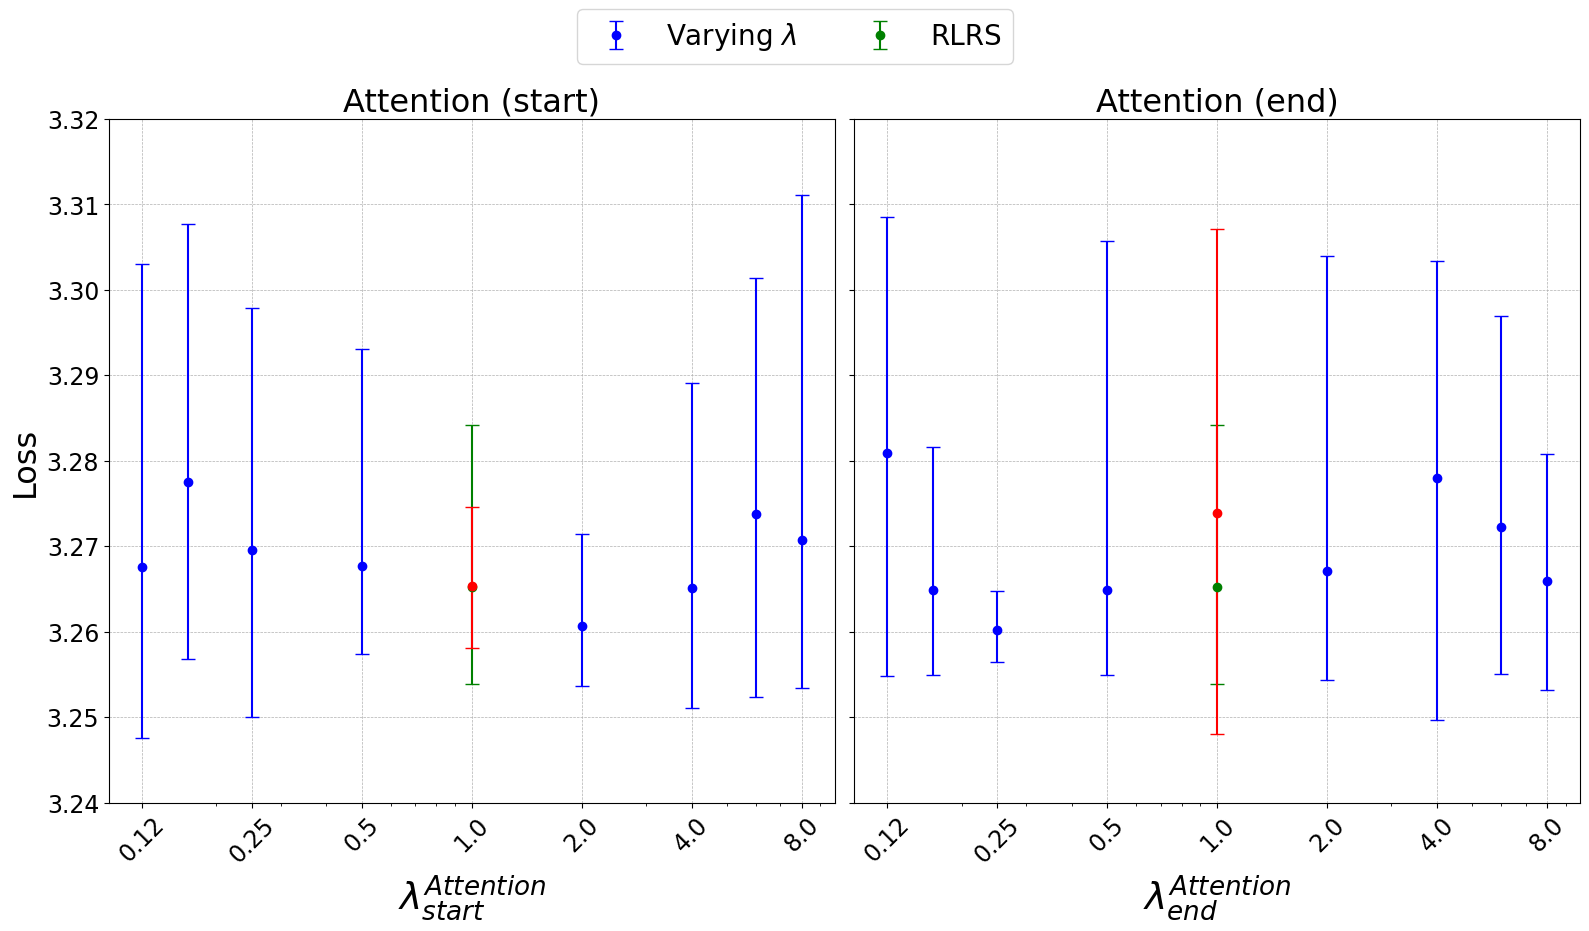

In [50]:
start_ends = ['start', 'end']
model_name = 'Base (100M)'

U_plot_component(
    model_name=model_name,
    u_plot_table=table,
    component_name='projection',
    start_ends=start_ends,
    figsize=(16, 9.5),
    ylim=(3.24, 3.32),
    title_fontsize=23, 
    xlabel_fontsize=27, 
    ylabel_fontsize=23, 
    tick_fontsize=17,
    legend_fontsize=20,
    row_spacing=0.58,
    legend_spacing=-0.01
)

## Component Removal

### Medium (30M)

In [23]:
model_type = 'medium_model'

component_names = ['embedding_layer', 'head', 'gating', 'expert_inner_function']
tags_relative = ['relativity_paper', model_type, 'removal', 'relative']
tags_baseline = ['relativity_paper', model_type, 'removal', 'baseline']
results_dict = None

for component in component_names:
    print(f'component: {component}')
    tags_component = ['relativity_paper', model_type, 'removal', component]

    baseline, relative, speedup = plot_std(
        runs_spec_type='tags',
        runs_1=tags_component,
        runs_2=tags_relative,
        title='Medium (33M)',
        name_1='Baseline',
        name_2='Relative',
        show_plot=False,
        save_to=None,
        ylim=(3.5, 4),
        x_start=0,
    )

    _, _, speedup_baseline = plot_std(
        runs_spec_type='tags',
        runs_1=tags_baseline,
        runs_2=tags_component,
        title='Medium (33M)',
        name_1='Baseline',
        name_2='Relative',
        show_plot=False,
        save_to=None,
        ylim=(3.5, 4),
        x_start=0,
    )

    results_dict = results_dict_append(component, baseline, relative, speedup, speedup_baseline, results_dict)

df = pd.DataFrame(results_dict)
print(df)
print()
print(df.to_latex())

component: embedding_layer
https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (10, 15)
https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (3, 15)
run ID: LLMRANDOM-16763
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16763
run ID: LLMRANDOM-16762
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16762
run ID: LLMRANDOM-16758
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16758
run ID: LLMRANDOM-16757
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16757
run ID: LLMRANDOM-16756
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16756
run ID: LLMRANDOM-16755
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16755
run ID: LLMRANDOM-16754
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16754
run ID: LLMRANDOM-15632
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15632
run ID: LLMRANDOM-15628
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15628
run ID: LLMRANDOM-15627
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-

### Base (100M)

In [24]:
model_type = 'base_model'

tags_component = ['embedding_layer', 'head', 'gating', 'expert_inner_function']
tags_relative = ['relativity_paper', model_type, 'removal', 'relative']
tags_baseline = ['relativity_paper', model_type, 'removal', 'baseline']
results_dict = None

for component in component_names:
    print(f'component: {component}')
    tags_component = ['relativity_paper', model_type, 'removal', component]

    baseline, relative, speedup = plot_std(
        runs_spec_type='tags',
        runs_1=tags_component,
        runs_2=tags_relative,
        title='Vase (100M)',
        name_1='Baseline',
        name_2='Relative',
        show_plot=False,
        save_to=None,
        ylim=(3.5, 4),
        x_start=0,
    )

    _, _, speedup_baseline = plot_std(
        runs_spec_type='tags',
        runs_1=tags_baseline,
        runs_2=tags_component,
        title='Base (100M)',
        name_1='Baseline',
        name_2='Relative',
        show_plot=False,
        save_to=None,
        ylim=(3.5, 4),
        x_start=0,
    )

    results_dict = results_dict_append(component, baseline, relative, speedup, speedup_baseline, results_dict)
    
df = pd.DataFrame(results_dict)
print(df)
print()
print(df.to_latex())

component: embedding_layer
https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (10, 15)
https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (3, 15)
run ID: LLMRANDOM-16817
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16817
run ID: LLMRANDOM-16815
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16815
run ID: LLMRANDOM-16814
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16814
run ID: LLMRANDOM-16813
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16813
run ID: LLMRANDOM-16812
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16812
run ID: LLMRANDOM-16811
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16811
run ID: LLMRANDOM-16810
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16810
run ID: LLMRANDOM-15597
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15597
run ID: LLMRANDOM-15596
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15596
run ID: LLMRANDOM-15595
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-

NeptuneConnectionLostException: 
[95m
----NeptuneConnectionLostException---------------------------------------------------------
[0m
The connection to the Neptune server was lost.
If you are using the asynchronous (default) connection mode, Neptune continues to locally track your metadata and continuously tries to re-establish a connection to the Neptune servers.
If the connection is not re-established, you can upload your data later with the Neptune Command Line Interface tool:
    [95mneptune sync -p workspace_name/project_name[0m

What should I do?
    - Check if your computer is connected to the internet.
    - If your connection is unstable, consider working in offline mode:
        [96mrun = neptune.init_run(mode="offline")[0m

You can find detailed instructions on the following doc pages:
    - https://docs.neptune.ai/api/connection_modes/#offline-mode
    - https://docs.neptune.ai/api/neptune_sync/

You may also want to check the following docs page:
    - https://docs.neptune.ai/api/connection_modes/#connectivity-issues

[92mNeed help?[0m-> https://docs.neptune.ai/getting_help


## Component Contribution

### Medium (30M)

In [25]:
model_type = 'medium_model'

tags_component = ['embedding_layer', 'head', 'gating', 'expert_inner_function']
tags_relative = ['relativity_paper', model_type, 'contribution', 'relative']
tags_baseline = ['relativity_paper', model_type, 'contribution', 'baseline']
results_dict = None

for component in component_names:
    print(f'component: {component}')
    tags_component = ['relativity_paper', model_type, 'removal', component]

    baseline, relative, speedup = plot_std(
        runs_spec_type='tags',
        runs_1=tags_component,
        runs_2=tags_relative,
        title='Medium (33M)',
        name_1='Baseline',
        name_2='Relative',
        show_plot=False,
        save_to=None,
        ylim=(3.5, 4),
        x_start=0,
    )

    _, _, speedup_baseline = plot_std(
        runs_spec_type='tags',
        runs_1=tags_baseline,
        runs_2=tags_component,
        title='Medium (33M)',
        name_1='Baseline',
        name_2='Relative',
        show_plot=False,
        save_to=None,
        ylim=(3.5, 4),
        x_start=0,
    )

    results_dict = results_dict_append(component, baseline, relative, speedup, speedup_baseline, results_dict)

df = pd.DataFrame(results_dict)
print(df)
print()
print(df.to_latex())

component: embedding_layer
https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (10, 15)
https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (3, 15)
run ID: LLMRANDOM-16763
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16763
run ID: LLMRANDOM-16762
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16762
run ID: LLMRANDOM-16758
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16758
run ID: LLMRANDOM-16757
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16757
run ID: LLMRANDOM-16756
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16756
run ID: LLMRANDOM-16755
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16755
run ID: LLMRANDOM-16754
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16754
run ID: LLMRANDOM-15632
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15632
run ID: LLMRANDOM-15628
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15628
run ID: LLMRANDOM-15627
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-

### Base (100M)

In [26]:
model_type = 'base_model'

tags_component = ['embedding_layer', 'head', 'gating', 'expert_inner_function']
tags_relative = ['relativity_paper', model_type, 'contribution', 'relative']
tags_baseline = ['relativity_paper', model_type, 'contribution', 'baseline']
results_dict = None

for component in component_names:
    print(f'component: {component}')
    tags_component = ['relativity_paper', model_type, 'removal', component]

    baseline, relative, speedup = plot_std(
        runs_spec_type='tags',
        runs_1=tags_component,
        runs_2=tags_relative,
        title='Base (100M)',
        name_1='Baseline',
        name_2='Relative',
        show_plot=False,
        save_to=None,
        ylim=(3.5, 4),
        x_start=0,
    )

    _, _, speedup_baseline = plot_std(
        runs_spec_type='tags',
        runs_1=tags_baseline,
        runs_2=tags_component,
        title='Base (100M)',
        name_1='Baseline',
        name_2='Relative',
        show_plot=False,
        save_to=None,
        ylim=(3.5, 4),
        x_start=0,
    )

    results_dict = results_dict_append(component, baseline, relative, speedup, speedup_baseline, results_dict)

df = pd.DataFrame(results_dict)
print(df)
print()
print(df.to_latex())

component: embedding_layer
https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (10, 15)
https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (3, 15)
run ID: LLMRANDOM-16817
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16817
run ID: LLMRANDOM-16815
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16815
run ID: LLMRANDOM-16814
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16814
run ID: LLMRANDOM-16813
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16813
run ID: LLMRANDOM-16812
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16812
run ID: LLMRANDOM-16811
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16811
run ID: LLMRANDOM-16810
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16810
run ID: LLMRANDOM-15597
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15597
run ID: LLMRANDOM-15596
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15596
run ID: LLMRANDOM-15595
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-